In [14]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import wandb

from m2_utilities.model.qwen import load_qwen
from m2_utilities.model.lora import apply_lora
from m2_utilities.model.infer import gen_points
from m2_utilities.model.train import train_model
from m2_utilities.data.load_data import load_trajectories
from m2_utilities.data.preprocessor import Preprocessor
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
model, tokenizer = load_qwen()

In [16]:
LORA_RANK = 4
apply_lora(model, LORA_RANK)

### Preprocessing Trajectories to Tokens

In [20]:
# Load
trajectories = load_trajectories("data/lotka_volterra_data.h5")

# Split
train_trajectories = trajectories[:700]
val_trajectories = trajectories[700:850]

# Preprocess
DECIMALS = 2
preprocessor = Preprocessor(DECIMALS)
train_ids = preprocessor.encode(train_trajectories, chunk=True, max_length=128)
val_ids = preprocessor.encode(val_trajectories)

In [21]:
# Initialising data loaders
BATCH_SIZE = 4
train_dataset = TensorDataset(train_ids)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(val_ids)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [19]:
print(len(train_loader.dataset))

4


### Training

In [22]:
LR = 1e-4
config = {"Learning Rate": LR,
          "Batch Size": BATCH_SIZE, 
          "Decimals": DECIMALS,
          "Lora Rank": LORA_RANK}
wandb.init(project="M2 Coursework", config=config)
wandb.watch(model, log="all", log_freq=10)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: at2128 (at2128-university-of-cambridge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [24]:
train_model(model, train_loader, val_loader, learning_rate=LR, eval_interval=50, max_steps=200, wandb=wandb)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Steps 0:  29%|██▊       | 200/700 [01:48<04:31,  1.84it/s, loss=0.651]


In [10]:
model.eval()
future_points = gen_points(model, val_trajectories[:, :80], n_points=20, decimals=2)

/rds/user/at2128/hpc-work/M2-Coursework/env_site/lib64/python3.11/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/rds/user/at2128/hpc-work/M2-Coursework/env_site/lib64/python3.11/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/rds/user/at2128/hpc-work/M2-Coursework/env_site/lib64/python3.11/site-packages/transformers/generation/configuration_utils.py:651: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`

Predator MRAEs: 0.5911051034927368
Prey MRAEs: 0.3162834942340851


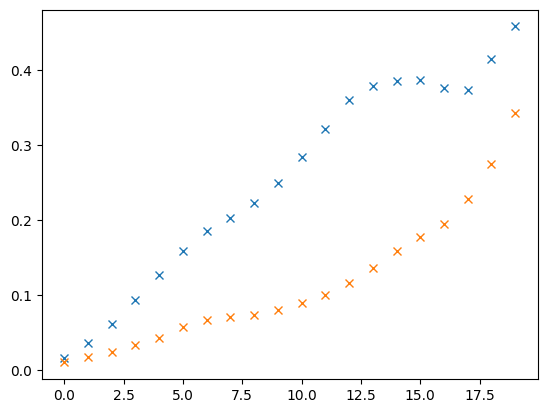

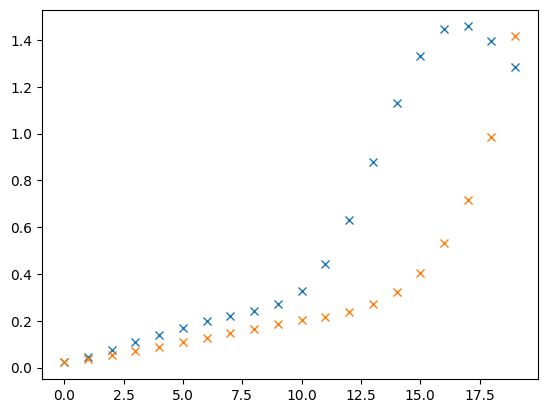

In [11]:
pred_maes, prey_maes, pred_mraes, prey_mraes = compute_metrics(val_trajectories[:, 80:], future_points)

print(f"Predator MRAEs: {torch.mean(pred_mraes)}")
print(f"Prey MRAEs: {torch.mean(prey_mraes)}")

plt.plot(torch.linspace(0, 19, 20), pred_maes, "x")
plt.plot(torch.linspace(0, 19, 20), prey_maes, "x")
plt.show()

plt.plot(torch.linspace(0, 19, 20), pred_mraes, "x")
plt.plot(torch.linspace(0, 19, 20), prey_mraes, "x")
plt.show()

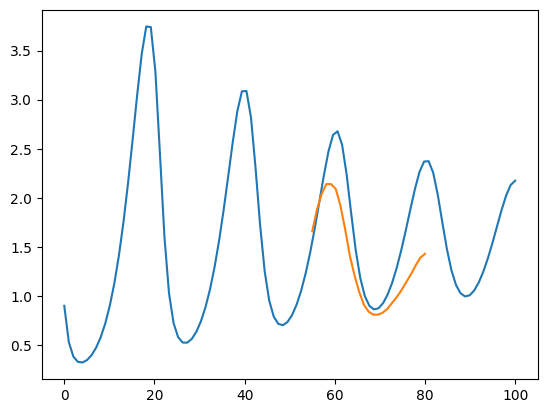

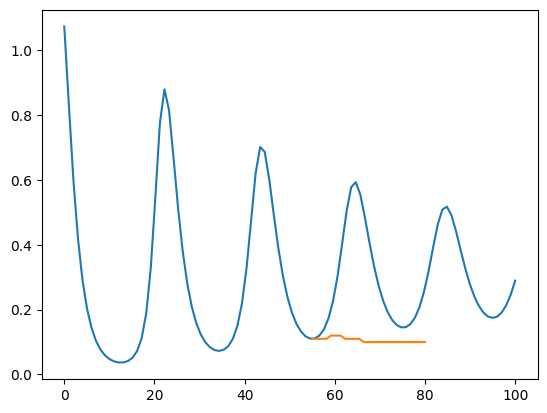

In [15]:
future_points = gen_points(model, val_trajectories[1:2, :55], n_points=25, decimals=2)

N_FORECAST = 25
plt.plot(torch.linspace(0, 100, 100), val_trajectories[1, :, 0])
plt.plot(torch.linspace(55, 55 + N_FORECAST, N_FORECAST), future_points[0, :, 0])
plt.show()

plt.plot(torch.linspace(0, 100, 100), val_trajectories[1, :, 1])
plt.plot(torch.linspace(55, 55 + N_FORECAST, N_FORECAST), future_points[0, :, 1])
plt.show()